In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int
from torchdiffeq import odeint
from collections import namedtuple
from tqdm.notebook import tqdm, trange

In [2]:
# better plots
sns.set_style('whitegrid')

# better progress
tqdm.pandas()

In [3]:
# read data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [4]:
in_time = torch.from_numpy(data_t).float()
in_CHO = torch.from_numpy(data_CHO).float()
in_insulin = torch.from_numpy(data_insulin).float()
in_CGM = torch.from_numpy(data_CGM).float()

In [5]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
mean_params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()
mean_params = mean_params.rename(lambda x: x.replace(" ", ""))
adult_params = orig_params[orig_params.Name.str.contains("adult")]

min_params = adult_params.min()
max_params = adult_params.max()

def get_param(p, p_min, p_max):
    return ((torch.tanh(p) + 1) / 2) * (p_max - p_min) + p_min

In [6]:
# system parameters
_kp2  = torch.tensor(mean_params["kp2"]) 
_k1   = torch.tensor(mean_params["k1"])
_k2   = torch.tensor(mean_params["k2"])
_kp1  = torch.tensor(mean_params["kp1"])
_ki   = torch.tensor(mean_params["ki"])
_ke1  = torch.tensor(mean_params["ke1"])
_kmax = torch.tensor(mean_params["kmax"])
_kmin = torch.tensor(mean_params["kmin"])
_kabs = torch.tensor(mean_params["kabs"])
_kp3  = torch.tensor(mean_params["kp3"])

In [7]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [8]:
def ode(t, x):
    # instantiate derivatives
    dxdt = torch.zeros(13)

    # parameters
    params = mean_params
    kabs = get_param(_kabs, min_params["kabs"], max_params["kabs"])
    kmax = get_param(_kmax, min_params["kmax"], max_params["kmax"])
    kmin = get_param(_kmin, min_params["kmin"], max_params["kmin"])
    k2 = get_param(_k2, min_params["k2"], max_params["k2"])
    k1 = get_param(_k1, min_params["k1"], max_params["k1"])
    ki = get_param(_ki, min_params["ki"], max_params["ki"])
    kp2 = get_param(_kp2, min_params["kp2"], max_params["kp2"])
    kp3 = get_param(_kp3, min_params["kp3"], max_params["kp3"])
    ke1 = get_param(_ke1, min_params["ke1"], max_params["ke1"])
    kp1 = get_param(_kp1, min_params["kp1"], max_params["kp1"])

    # get current action
    t_mask = torch.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = kmin + (kmax - kmin) / 2 * (
            torch.tanh(aa * (qsto - params.b * Dbar))
            - torch.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = kmax

    # stomach liquid
    dxdt[1] = kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - kabs * x[2]

    # Rate of appearance
    Rat = params.f * kabs * x[2] / params.BW
    # Glucose Production
    EGPt = kp1 - kp2 * x[3] - kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - k1 * x[3] + k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + k1 * x[3] - k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -ki * (x[7] - It)

    dxdt[8] = -ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt

In [9]:
# initial conditions
f_0 = torch.tensor(mean_params.iloc[2:15], dtype=torch.float32)

In [10]:
# timespan
tspan = (data_t[0], data_t[-1])

In [11]:
# enfore ICs
def output_transform(t, u, u_0):
    return u * torch.tanh(t) + u_0

In [12]:
# loss criterion
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [13]:
# generate features
t = torch.FloatTensor(100, 1).uniform_(*tspan)
t.requires_grad_(True)

# ODE loss
def ode_loss(model, ode, criterion, f_0):
    # get preds
    NN_t = model(t)
    NN_t = output_transform(t, NN_t, f_0)

    dNN_dt = torch.hstack([
        autograd.grad(
            NN_t[:, i:i+1],
            t,
            grad_outputs=torch.ones_like(t),
            create_graph=True,
            retain_graph=True,
        )[0]
        for i in range(13)
    ])

    df_dt = torch.vstack([ode(t_i, x_i) for (t_i, x_i) in zip(t, NN_t)])

    loss = criterion(dNN_dt, df_dt)

    return loss

In [14]:
# train model for given number of epochs
def train(model, opt, criterion, epochs, informed=False, logfreq=100):

    # train model
    loss_history = []
    for epoch in (pbar := trange(epochs)):
        opt.zero_grad()

        features = in_time.reshape(-1, 1)
        preds = model(features)[:, 12:13] / mean_params.Vg
        loss = criterion(preds, in_CGM.reshape(-1, 1))

        # ode loss
        if informed:
            loss += ode_loss(model, ode, criterion, f_0)

        loss.backward()
        opt.step()

        if epoch % logfreq == 0 or epoch == epochs - 1:
            pbar.set_postfix(loss=f"{loss.item():.2e}")
            loss_history.append(loss.item())

    return loss_history

In [15]:
# network
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 13),
)

# optimizer
opt = optim.Adam(model.parameters())

# loss
criterion = RMSLELoss()

In [16]:
# train network
epochs = 10_000
loss_history = train(model, opt, criterion, epochs)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

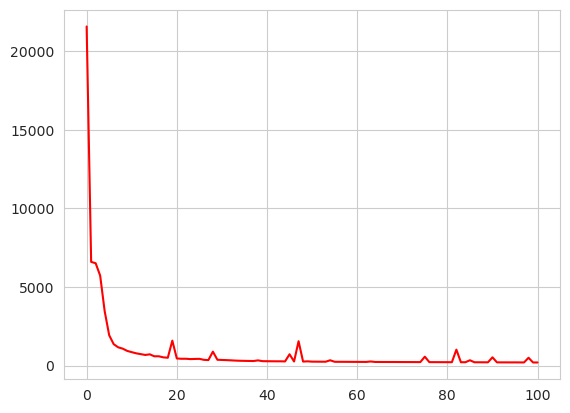

In [ ]:
plt.plot(loss_history, "r")
plt.show()

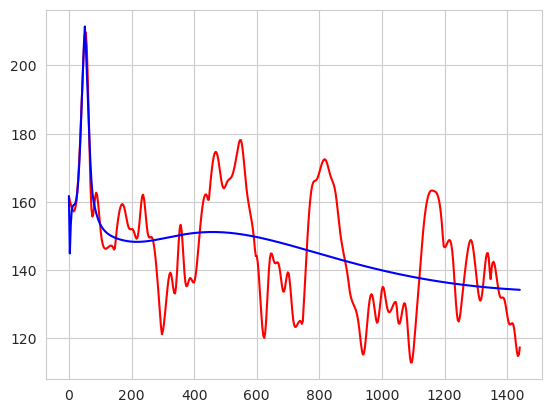

In [ ]:
# predictions
plt.plot(in_time, in_CGM, "r")
plt.plot(in_time, model(in_time.reshape(-1, 1)).detach()[:, 12:13] / mean_params.Vg, "b")
plt.show()

In [ ]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [ ]:
# train network (informed loss)
epochs = 1000
loss_history = train(model, opt, criterion, epochs, informed=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 